# Correlation Grid

In [11]:
%load_ext autoreload
%autoreload 2

from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import cartopy.crs as ccrs
import cartopy
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.cluster import KMeans
from temp_clustering import cluster_temp_diff
from scipy.stats import pearsonr
from tqdm import tqdm
from Smoothed_Values import Smoothed_Temp_Solar
from plot_map import plot_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset(path_data / 'T2m_R2_ym_1stMill.nc')

In [13]:
aod = ds_volc['AOD'].values.flatten()
temp, solar = Smoothed_Temp_Solar(ds_temp_r1['T2m'].values, ds_solar['TSI'].values.flatten())

In [14]:
def grid_pearson(n_splits, target_values):
    lon = ds_temp_r1['lon'].values
    lat = ds_temp_r1['lat'].values

    lat_labels = np.digitize(lat, np.linspace(np.min(lat), np.max(lat), n_splits, endpoint=False))
    lon_labels = np.digitize(lon, np.linspace(np.min(lon), np.max(lon), n_splits, endpoint=False))

    lons_mat, lats_mat = np.meshgrid(lon_labels, lat_labels)

    pearson_grid = np.zeros((96, 192))

    for c1 in np.unique(lat_labels):
        for c2 in np.unique(lon_labels):
            block = (lons_mat == c2) & (lats_mat == c1)
            temps = np.mean(ds_temp_r1['T2m'].values[:, block], axis=1)
            pearson_grid[block] = pearsonr(temps, target_values)[0]

    return pearson_grid

In [15]:
aod_grid = []

for g in tqdm(range(1, 50, 1)):
    aod_grid.append(grid_pearson(g, aod))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


In [16]:
solar_grid = []

for g in tqdm(range(1, 50, 1)):
    solar_grid.append(grid_pearson(g, solar))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


In [21]:
def interactive_plot(grid_data):
    lats = ds_temp_r1.variables['lat'][:]
    lons = ds_temp_r1.variables['lon'][:]

    def plot_pearson_map(split_index):
        return plot_map(grid_data[split_index], title=f'N_splits= {split_index+1}, max(|pearson|)={np.max(np.abs(grid_data[split_index])):.2}')

    split_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(grid_data) - 1,
        step=1,
        description='n_splits:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    interact(plot_pearson_map, split_index=split_slider)

In [22]:
interactive_plot(aod_grid)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n_splits:', max=48), Output()),…

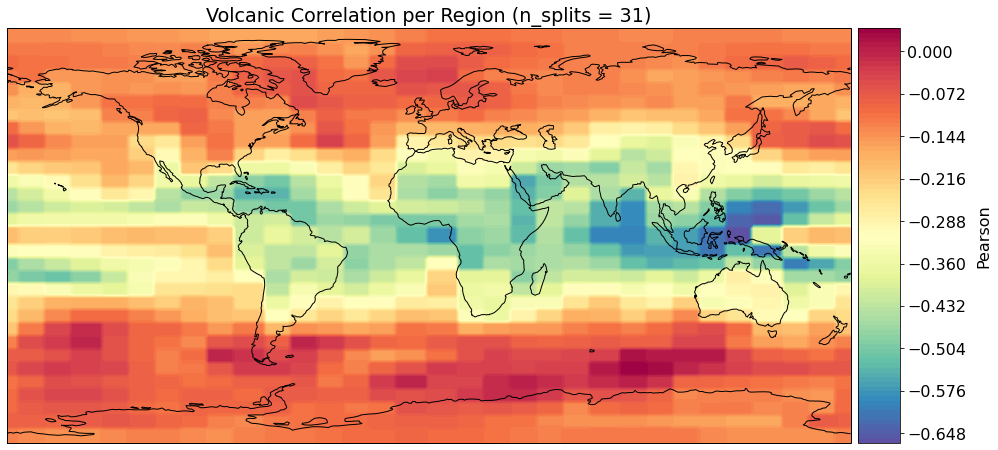

In [28]:
split_index = 30
title = f'Volcanic Correlation per Region (n_splits = {split_index+1})'
fig = plot_map(aod_grid[split_index], title=title, colorbar_title='Pearson')
fig.savefig(f'../results/map_pearson_volc-{split_index}.png', dpi=300, bbox_inches='tight')
fig

In [9]:
#np.save('../results/volc_mask_pearson.npy', np.min(aod_grid[20]) == aod_grid[20])
#with np.printoptions(threshold=np.inf):
    #print()

In [23]:
# for sg in solar_grid:
#     print(np.max(sg))

interactive_plot(solar_grid)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n_splits:', max=48), Output()),…

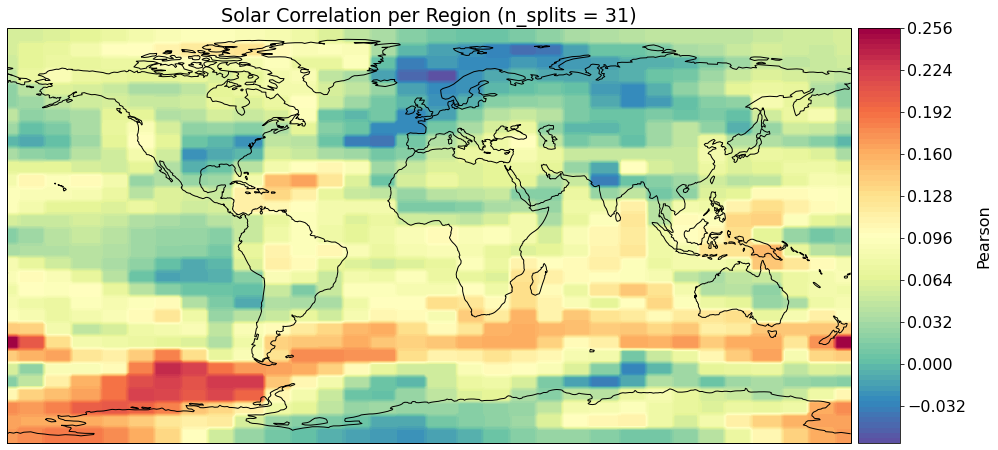

In [29]:
split_index = 30
title = f'Solar Correlation per Region (n_splits = {split_index+1})'
fig = plot_map(solar_grid[split_index], title=title, colorbar_title='Pearson')
fig.savefig(f'../results/map_pearson_solar-{split_index}.png', dpi=300, bbox_inches='tight')
fig